<h1><center>Машинное обучение. Кластеризация новостных текстов</center></h1>
<center>Бакаров Амир, Никишина Ирина, Степачёв Павел </center>
<center>Национальный исследовательский университет "Высшая школа экономики"</center>

**Абстракт**. Лемматизация -- процесс приведения слова к его нормальной форме; этот процесс уникален для каждого языка, поскольку набор словоизменительных аффиксов варьируется от языка к языку. Для русского языка на данный момент существующих три популярных алгоритма лемматизации: pymorphy2, mystem и texterra. При этом не существует исследования, в котором бы рассматривалось влияние выбора алгоритма лемматизации на качество решения задачи кластеризации данных -- процессу разбиения множества объектов на сравнительно однородные группы. Данное исследование призвано заполнить этот пробел в научном знании и посвящено сравению различных алгоритмов лемматизации русского языка в задаче кластеризации набора новостных текстов. Для того, чтобы подтвердить, что зависимость качества кластеризации неразрывано связана с используемым алгоритмом лемматизации, мы используем несколько различных методов векторизации текста и алгоритмов кластеризации. В качестве размеченного датасета мы используем корпус русскоязычных новостных сводок за 2017 год, предоставленный Екатериной Черняк.

### Введение

Кластерный анализ, или кластеризация (cluster analysis) — один из возможных классов задач в машинном обучении (наряду с классификацией, регрессией и определением аномалией), сводящийся к разбиению неоднородного множества объектов в сравнительно однородные группы. В обработке естественного языка кластеризация обычно используется для автоматического выделения из множества документов тематически схожих без использования обучающей выборки -- к примеру, для разделения новостей на группы в новостных аггрегаторах.

Существенная особенность задач по обработке естественного языка (по сравению с другими задачами машинного обучения) заключается в том, что данные представлены в "сыром виде", и качество решения задачи напрямую зависит от выбранного метода преобразования данных в числовой вид. При этом известно, что качество решения задачи повысится, если применить к "сырому тексту" процедуры, удаляющие из текста шум. Одним из примеров такого шума может выступать излишнее многообразие словоформ -- разных форм одного и того же слова. Процедура, приводящая слоформы к одному и тому же слову, называется лемматизацией. Для русского языка существует три алгоритма лемматизации: pymorphy2, mystem и texterra. При этом неизвестно, каким образом эти алгоритмы влияют на качество кластеризации. Целью данного исследования и является выявление производительности этих алгоритмов в задаче кластеризации. Данная работа является первой работой, в которой рассматривается зависимость успешности решения задачи кластеризации для русского языка от используемого алгоритма лемматизации; в этом факте и заключается научная новизна данного исследования.

Работа устроена следующим образом. В разделе 1 рассматриваются особенности корпуса Екатерины Черняк. В разделе 2 описываются используемые алгоритмы лемматизации. В разделе 3 приводится обзор существующих классов алгоритмов векторизации "сырого текста", в то время как раздел 4 посвящен алгоритмам кластеризации и метрикам оценки качества. В разделе 5 обсуждаются полученные результаты, и раздел 6 завершает статью.

Все эксперименты в данном исследовании проводятся на языке программирования Python 3.6.3 с использованием следующих библиотек: 

In [134]:
from os import path
import glob
import pickle
import gensim
import numpy as np
import time

from nltk.tokenize import RegexpTokenizer, word_tokenize
from re import sub

from pandas import DataFrame, options

from pymystem3 import Mystem
import texterra
from pymorphy2 import MorphAnalyzer
import pandas

import codecs
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import *
from sklearn.cluster import *
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import *
import scipy.cluster.hierarchy as hac

import matplotlib.pyplot as plt
import seaborn as sns

from difflib import SequenceMatcher

API_KEY = '9988cfb979b80264baeba1386cc7e455f99f943c'

morph = MorphAnalyzer()
m = Mystem()
t = texterra.API(API_KEY)
alpha_tokenizer = RegexpTokenizer('\w+')

### Анализ данных

Новостной корпус Екатерины Черняк представлен данными в файлах 'events.csv' (заголовки новостных событий) и 'raw_news.csv' (тексты новостей с метками событий):

In [178]:
df_events = DataFrame.from_csv('events.csv')
df_news = DataFrame.from_csv('raw_news.csv')
texts = list(df_news.text.values)

Данные имеют вид таблицы из двух столбцов -- текста новости и метки события, о котором в нём идет речь.

In [3]:
options.display.max_colwidth = 120
df_news.head()

,event_id,text
0,1,В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИСААКИЕВСКОГО СОБОРА РПЦ В Санкт-Петербурге люди устроили акцию протеста...
1,1,"Lenta.co, Москва, 14 января 2017 СИТУАЦИЯ С ПЕРЕДАЧЕЙ ИСААКИЕВСКОГО СОБОРА В ВЕДЕНИЕ РПЦ. ИСТОРИЯ СОБОРА Читать ори..."
2,1,"Аргументы и Факты (aif.ru), Москва, 14 января 2017 ОППОЗИЦИЯ ПРОВЕЛА МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИСААКИЕВСКОГО СОБОРА РП..."
3,1,"Google Новости ТОП, Москва, 14 января 2017 АКЦИЯ ПРОТИВ ПЕРЕДАЧИ ИСААКИЕВСКОГО СОБОРА РПЦ ПРОШЛА БЕЗ НАРУШЕНИЙ Моск..."
4,1,"Газета.Ru, Москва, 13 января 2017 В МОСКОВСКОЙ ПАТРИАРХИИ ПРОКОММЕНТИРОВАЛИ ПЕРЕДАЧУ ИСААКИЕВСКОГО СОБОРА РПЦ Руков..."


Таким образом, каждая новость представлена в виде фрагмента текста и имеет метку о принадлежности к определенному событию. Одному событию может соотвествовать несколько новостей, но каждая новости ассоциировано только одно событие; диаграмма ниже показывает, как распределены события по новостям:

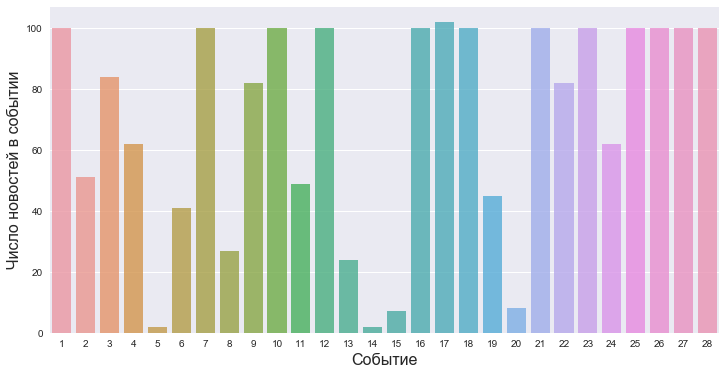

In [13]:
events = df_news.event_id.value_counts()
plt.figure(figsize=(12,6))
sns.barplot(events.index, events.values, alpha=0.8)
plt.ylabel('Число новостей в событии', fontsize=16)
plt.xlabel('Событие', fontsize=16)
plt.show();

Рассмотрим распределение новостей по числу токенов в её тексте. Как видно, подавляющее большинство новостей содержит достаточно малое число токенов:

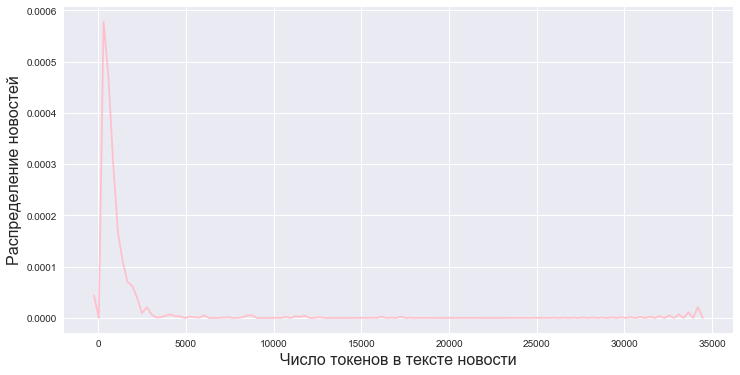

In [21]:
plt.figure(figsize=(12,6))
sns.distplot(df_news.text.apply(lambda string: len(word_tokenize(string))), bins=100, rug=False, hist=False, color='pink')
plt.ylabel('Распределение новостей', fontsize=16)
plt.xlabel('Число токенов в тексте новости', fontsize=16)
plt.show()

Корпус также содержит дубликаты некоторых новостей (6 одинаковых объектов):

In [179]:
df_news[df_news.duplicated()]

,event_id,text
513,9,"Коммерсантъ. Новости информ. центра, Москва, 23 марта 2017 СМИ: УБИЙЦА ВОРОНЕНКОВА НАХОДИТСЯ В РОЗЫСКЕ ПО ДЕЛУ ОБ О..."
518,9,"Коммерсантъ. Новости информ. центра, Москва, 23 марта 2017 МВД УКРАИНЫ ПО ФАКТУ ГИБЕЛИ ВОРОНЕНКОВА ВОЗБУДИЛО ДЕЛО П..."
522,9,"Коммерсантъ. Новости информ. центра, Москва, 23 марта 2017 ДЕНИС ВОРОНЕНКОВ БЫЛ УБИТ ИЗ ПИСТОЛЕТА ТТ Установлено ор..."
526,9,"Коммерсантъ. Новости информ. центра, Москва, 23 марта 2017 ПОРОШЕНКО НАЗВАЛ УБИЙСТВО ВОРОНЕНКОВА ""АКТОМ ТЕРРОРИЗМА ..."
528,9,"Коммерсантъ. Новости информ. центра, Москва, 23 марта 2017 ГЕНПРОКУРАТУРА УКРАИНЫ ПОДОЗРЕВАЕТ РОССИЮ В ПРИЧАСТНОСТИ..."
536,9,"Коммерсантъ. Новости информ. центра, Москва, 23 марта 2017 ВЛАДИМИРУ ПУТИНУ ДОЛОЖИЛИ ОБ УБИЙСТВЕ БЫВШЕГО ДЕПУТАТА Д..."


Таким образом, размер корпуса без дубликатов составляет 1924 новости:

In [5]:
df_news = df_news.drop_duplicates()
print(len(df_news))

1924


### Предобработка текста

В данной работе рассматриваются три алгоритма лемматизации, существующие в виде модулей для языка Python:

* pymorphy2 
* mystem
* texterra

Стоит заметить, что texterra не является открытым модулем, и посылает запросы к API, находящемся на удалённом сервере.

In [4]:
def normalize_with_pymorphy(tokens):
    return [morph.parse(word)[0].normal_form for word in tokens]

def normalize_with_mystem(tokens):
    return ''.join(m.lemmatize(' '.join(tokens))).split()

def normalize_with_texterra(tokens):
    time.sleep(10)
    text = ' '.join(tokens)
    return [token[3] for token in list(t.lemmatization(text))[0]]

Качество работы различных алгоритмов можно наглядно рассмотреть на задаче разрешения контекстной омономии, используя в качестве примера фразу *"Поля в поле моет пол и заполнила пол поля"*. Разобъем это предложение на токены (отдельные значимые единицы, в данном случае являющиеся словами) и применим к токенам рассмотренные алгоритмы леммаизации. Качество решения задачи оценивается с помощью золотого стандарта 'поля в поле мыть пол и заполнить половина поле', указанного при помощи людей на основе метрики Gestalt Pattern Matching.

In [ ]:
tricky_text = 'Поля в поле моет пол и заполнила пол поля'
gold_standard_normalized = 'поля в поле мыть пол и заполнить половина поле'

In [9]:
for normalizer, normalize in [('Pymorphy2', normalize_with_pymorphy),
                              ('MyStem', normalize_with_mystem),
                              ('Texterra', normalize_with_texterra)]:
    normalized_text = ' '.join(normalize((alpha_tokenizer.tokenize(tricky_text))))
    print('{}: {:0.2f} ({})'.format(normalizer, SequenceMatcher(None, gold_standard_normalized, normalized_text).ratio(), normalized_text))

Pymorphy2: 0.90 (поль в пол мыть половина и заполнить половина поль)
MyStem: 0.87 (поле в поле мыть пол и заполнять пол поля)
Texterra: 0.88 (поле в поле мывать пол и заполнять пол поле)


В этом исследовании мы получим три варианта исходного "сырого текста", лемматизированного при помощи трёх разных алгоритмов, и проверим, на каком из них какие получатся результаты:

In [6]:
all_type_of_tokens = {}
tokenizers = {'pymorphy': normalize_with_pymorphy, 'texterra': normalize_with_texterra, 'mystem': normalize_with_mystem}

Данные предварительно сериализованы в .pickle-файлы для того, чтобы впоследствии к ним можно было удобно обращаться:

In [ ]:
for name, tokenizer in tokenizers.items():
    all_texts = []
    for text in texts:
        text = sub(r'http\S+', '', text)
        tokens = alpha_tokenizer.tokenize(text)
        tokens = tokenizer(tokens)
        all_texts.append(tokens)
    with open('tokens_from_' + name + '.pickle', 'wb') as f:
        pickle.dump(all_texts, f)

In [8]:
data = {}
for filename in glob.iglob('lemmas_from_*.pickle', recursive=True):
    with open(filename, 'rb') as f:
        data_lemmas = pickle.load(f)
        data[path.splitext(path.basename(filename))[0]] = data_lemmas

### Векторизация

Существует три типа основных метода векторизации, которые мы выделяем:

* Матричная факторизация (применение алгоритмов LSA или SVD для понижения размерности матрицы совместной встречаемости, получаемой для слов относительно всего текста (CountVectorizer), либо относительно слов по отношению к документам (Tf-Idf-Vectorizer))
* Дистрибутивные семантические модели, эмбеддинги слов (алгоритмы, строящие вектора фиксированной размерности, полученные на softmax-слое нейронной сети, максимизирующей вероятность встретить слово на основании его контекста (Continious Bag of Words), либо, наоборот, встретить контекст на основе слова (Skip-Gram))
* Эмбеддинги предложений (алгоритмы, строящие вектора не только для слов, но и для предложений)

В данном исследовании с помощью модуля gensim были обучены модели Word2Vec (CBOW) и Doc2Vec, использовавшиеся для получения векторов для каждой новости:

Вектора слов, полученные с помощью Word2Vec, складывались и усреднялись:

In [ ]:
num_of_features = 200

for name_of_alg, list_of_docs in data.items():
    model = gensim.models.Word2Vec(list_of_docs, size=num_of_features, min_count=30, window=30)
    model.save(name_of_alg.replace('lemmas','w2v_model2')+'.mdl')
    
    vectors_list = []
    
    for text_id in range(len(list_of_docs)):
        vector_for_each_text = []
        
        for word in list_of_docs[text_id]:
            try:
                featureVec = np.zeros(shape=(1, num_of_features), dtype='float32')
                featureVec = np.add(featureVec, model[word])
                vector_for_each_text.append(featureVec)
            except KeyError:
                pass

        first_vector = np.array(vector_for_each_text[0])
        for i in range(1, len(vector_for_each_text)):
            first_vector = np.add(first_vector, vector_for_each_text[i])
            
        resultVec = np.divide(first_vector, len(vector_for_each_text))
        vectors_list.append(resultVec)

    vectors_array = np.array(vectors_list[0])
    for i in range(1, len(vectors_list)):
        vectors_array = np.vstack((vectors_array,vectors_list[i]))

    with open(name_of_alg.replace('lemmas', 'vectors2')+ '.pickle', 'wb') as f:
            pickle.dump(np.matrix(vectors_array), f)

Такая же операция производилась и с Doc2Vec:

In [ ]:
for name_of_alg, list_of_docs in data.items():
    
    sentences = [gensim.models.doc2vec.TaggedDocument(words=list_of_docs[doc], tags=[u'text']) for doc 
                 in range(len(list_of_docs))]
    model = gensim.models.doc2vec.Doc2Vec(sentences, size=num_of_features, min_count=70, window=70)
    model.save(name_of_alg.replace('lemmas', 'd2v_model') + '.mdl')
    model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

    vectors_list = []
    for text_id in range(len(list_of_docs)):
        vector_for_each_text = []
        for word in list_of_docs[text_id]:
            try:
                featureVec = np.zeros(shape=(1, num_of_features), dtype='float32')
                featureVec = np.add(featureVec, model[word])
                vector_for_each_text.append(featureVec)
            except KeyError:
                pass
        first = np.array(vector_for_each_text[0])

        for i in range(1, len(vector_for_each_text)):
            first = np.add(first, vector_for_each_text[i])
        resultVec = np.divide(first, len(vector_for_each_text))
        vectors_list.append(resultVec)

    vectors_array = np.array(vectors_list[0])

    for i in range(1, len(vectors_list)):
        vectors_array = np.vstack((vectors_array, vectors_list[i]))
        
    with open(name_of_alg.replace('lemmas', 'vectors_d2v') + '.pickle', 'wb') as f:
            pickle.dump(np.matrix(vectors_array), f)

### Кластеризация

В данном исследовании используются три алгоритма кластеризации, представленные в библиотеке ```scikit-learn```.

**Метод k-means** — метод кластеризации, основанный на минимизации суммарного квадратичного отклонения точек кластеров от их центроидов:
${\displaystyle V=\sum _{i=1}^{k}\sum _{x_{j}\in S_{i}}(x_{j}-\mu _{i})^{2}} V=\sum _{i=1}^{k}\sum _{x_{j}\in S_{i}}(x_{j}-\mu _{i})^{2}$
где $k$ — число кластеров, $S_{i}$ — полученные кластеры, $i=1,2,\dots ,k$ и $\mu _{i}$ — центры масс векторов $x_{j}\in S_{i}$.

**Метод Agglomerative Clustering** -- иерархический метод кластеризации, работающий "снизу вверх". В нём каждый объект из выборки получает собственный кластер, и далее пары кластеров итеративно объединяются в соответствии с заданными условиями, пока не получится желаемое число кластеров.

**Метод Ши-Малика (Spectral Clustering)** -- метод кластеризации, который использует спектр (собственные значения) матрицы подобия данных (количественной оценки относительного сходства каждой пары точек в наборе данных) меньшей размерности. 

In [9]:
list_of_alg = [KMeans, AgglomerativeClustering, SpectralClustering]

Для оценки в качестве золотого стандарта используются проставленные людьми метки новостей из ```raw_news.csv```. Чтобы проверить качество работы алгоритмов на кластеры, используются следующие метрики:

* **Adjusted Rand Index** ((RI - Expected_RI) / (max(RI) - Expected_RI)
* **Homogenity** -- результат кластеризации удовлетворяет требованию homogenity, если все его кластеры содержат только точки данных, которые являются членами одного класса.
* **Completeness** -- результат кластеризации удовлетворяет требованию completeness, если все точки данных, являющиеся членами данного класса, являются элементами одного и того же кластера.
* **V-score** (среднее гармоническое между homogeneity и completeness: V = 2 * (homogeneity * completeness) / (homogeneity + completeness)

In [82]:
labels = list(df_news.event_id)

Итак, для каждого типа лемматизированного текста используются 3 разных класса методов векторизации и 3 разных алгоритма кластеризации. Программный код для реализации этого эксперимента оформляется в виде инструмента ```pipeline``` модуля ```scikit-learn```:

In [252]:
def pipeline_executor(data_model, alg, n_clusters=28):
    pipeline = Pipeline([('tfidf', TfidfTransformer()),
                                 ('svd', TruncatedSVD(n_components=150)),
                                 ('norm', Normalizer()),
                                 ('clust', alg(n_clusters=n_clusters))
                                ])
    pipeline.fit(data_model)
            
    explained_variance = pipeline.named_steps['svd'].explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))
                        
    clust_labels = pipeline.named_steps['clust'].labels_

    print("Homogeneity:", homogeneity_score(labels, clust_labels))
    print("Completeness:", completeness_score(labels, clust_labels))
    print("V-measure",  v_measure_score(labels, clust_labels))
    ari= adjusted_rand_score(labels, clust_labels)
    print("Adjusted Rand-Index:",  ari)
    print('==============')
    return (ari, confusion_matrix(labels, clust_labels))
    

Итак, для каждого типа лемматизированного текста используются 3 разных класса методов векторизации и 3 разных алгоритма кластеризации. Программный код для реализации этого эксперимента оформляется в виде инструмента ```pipeline``` модуля ```scikit-learn```:

In [222]:
ari_dict = {}
cfm_dict = {}

С помощью заранее сериализованных векторов текстов новостей, полученный с помощью Word2Vec, создавются словари:

In [223]:
data_models = {}
for filename in glob.iglob('vectors_w2v*.pickle', recursive=True):
    with open(filename, 'rb') as f:
        data_model = pickle.load(f)
        data_models[filename.replace('.pickle', '')] = data_model
for name, model in data_models.items():
    for alg in list_of_alg:
        print(alg, name)
        ari, cfm = pipeline_executor(data_model,alg)
        ari_dict[ari] = name
        cfm_dict[name] = cfm       

<class 'sklearn.cluster.k_means_.KMeans'> vectors_w2v_from_texterra
Explained variance of the SVD step: 99%
Homogeneity: 0.840502857497
Completeness: 0.815909617926
V-measure 0.828023666208
Adjusted Rand-Index: 0.661636563509
<class 'sklearn.cluster.hierarchical.AgglomerativeClustering'> vectors_w2v_from_texterra
Explained variance of the SVD step: 99%
Homogeneity: 0.858866770617
Completeness: 0.844341076052
V-measure 0.851541982626
Adjusted Rand-Index: 0.702140661018
<class 'sklearn.cluster.spectral.SpectralClustering'> vectors_w2v_from_texterra
Explained variance of the SVD step: 99%
Homogeneity: 0.854660577024
Completeness: 0.825687659663
V-measure 0.839924339779
Adjusted Rand-Index: 0.661752706396
<class 'sklearn.cluster.k_means_.KMeans'> vectors_w2v_from_pymorphy
Explained variance of the SVD step: 99%
Homogeneity: 0.857773151803
Completeness: 0.838825516496
V-measure 0.848193530434
Adjusted Rand-Index: 0.70454501694
<class 'sklearn.cluster.hierarchical.AgglomerativeClustering'> v

Аналогичная операция производится с Doc2Vec:

In [224]:
data_models = {}
for filename in glob.iglob('vectors_d2v_*.pickle', recursive=True):
    with open(filename, 'rb') as f:
        data_model = pickle.load(f)
        data_models[filename.replace('.pickle', '')] = data_model
for name, model in data_models.items():
    for alg in list_of_alg:
        print(alg, name)
        ari, cfm = pipeline_executor(data_model,alg)
        ari_dict[ari] = name
        cfm_dict[name] = cfm 

<class 'sklearn.cluster.k_means_.KMeans'> vectors_d2v_from_texterra
Explained variance of the SVD step: 99%
Homogeneity: 0.904784593878
Completeness: 0.871442952948
V-measure 0.887800844751
Adjusted Rand-Index: 0.781620577042
<class 'sklearn.cluster.hierarchical.AgglomerativeClustering'> vectors_d2v_from_texterra
Explained variance of the SVD step: 99%
Homogeneity: 0.904446914495
Completeness: 0.883663924457
V-measure 0.893934640421
Adjusted Rand-Index: 0.788155788567
<class 'sklearn.cluster.spectral.SpectralClustering'> vectors_d2v_from_texterra
Explained variance of the SVD step: 99%
Homogeneity: 0.899470900987
Completeness: 0.868176522702
V-measure 0.883546694466
Adjusted Rand-Index: 0.759181498759
<class 'sklearn.cluster.k_means_.KMeans'> vectors_d2v_from_mystem
Explained variance of the SVD step: 99%
Homogeneity: 0.919855325725
Completeness: 0.887568580247
V-measure 0.903423577378
Adjusted Rand-Index: 0.82838770568
<class 'sklearn.cluster.hierarchical.AgglomerativeClustering'> vec

И не менее аналогичная операция производится с векторами факторизованной TF-IDF-матрицы:

In [225]:
data_models = {}
for name in glob.iglob('lemmas_from_*.pickle', recursive=True):
    with open(name, 'rb') as g:
        lemmas = pickle.load(g)
    words_list = [' '.join([word for word in sentence]) for sentence in lemmas]
    tf_idf = TfidfVectorizer(ngram_range=(1,3))
    data_models[name.replace('.pickle', '').replace('lemmas','tf-idf')] = tf_idf.fit_transform(words_list)
for name, model in data_models.items():
    for alg in list_of_alg:
        print(alg, name)
        ari, cfm = pipeline_executor(data_model,alg)
        ari_dict[ari] = name
        cfm_dict[name] = cfm 

<class 'sklearn.cluster.k_means_.KMeans'> tf-idf_from_texterra
Explained variance of the SVD step: 99%
Homogeneity: 0.902376025292
Completeness: 0.877132104926
V-measure 0.889575011273
Adjusted Rand-Index: 0.787701464734
<class 'sklearn.cluster.hierarchical.AgglomerativeClustering'> tf-idf_from_texterra
Explained variance of the SVD step: 99%
Homogeneity: 0.904446914495
Completeness: 0.883663924457
V-measure 0.893934640421
Adjusted Rand-Index: 0.788155788567
<class 'sklearn.cluster.spectral.SpectralClustering'> tf-idf_from_texterra
Explained variance of the SVD step: 99%
Homogeneity: 0.901325854256
Completeness: 0.870765755944
V-measure 0.885782297389
Adjusted Rand-Index: 0.77658239386
<class 'sklearn.cluster.k_means_.KMeans'> tf-idf_from_pymorphy
Explained variance of the SVD step: 99%
Homogeneity: 0.902435432505
Completeness: 0.870218491482
V-measure 0.88603420003
Adjusted Rand-Index: 0.782716162431
<class 'sklearn.cluster.hierarchical.AgglomerativeClustering'> tf-idf_from_pymorphy
E

Предполагая, что в данной задаче метрика Adjusted Rand Index отражает абсолютное качество, делаем вывод, что наиболее качественную кластеризацию проводят следующие комбинации алгоритмов:

In [22]:
# а че за модель кластеризации-то

In [226]:
sorted_ari = sorted(ari_dict.keys(), reverse=True)
for i in range(3):
    print('{}: {}'.format(ari_dict[sorted_ari[i]], sorted_ari[i]))

0.82838770568 ===== vectors_d2v_from_mystem
0.802480119123 ===== tf-idf_from_mystem
0.792913370472 ===== vectors_d2v_from_pymorphy


Как можно видеть, наилучший результат был достигнут при векторизации моделью Doc2Vec данных, предобработанных при помощи алгоритма MyStem. При этом MyStem показал высокое качество и при векторизации при использовании в качестве векторизатора факторизованной матрицы TF-IDF; впрочем, Word2Vec-векторизация этих данных не позволила добиться такого же качества решения задачи. Более наглядно полученные результаты характеризует следующая дендрограмма:

In [23]:
# увеличить шрифт и сам график

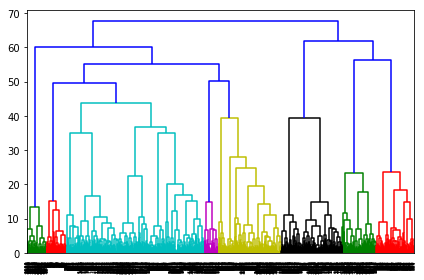

In [229]:
max_ari = ari_dict[max(sorted_ari)]
with open(max_ari+'.pickle', 'rb') as g:
    vectors = pickle.load(g)
    z = hac.linkage(a, method='ward')
    hac.dendrogram(z)
    plt.tight_layout()
    plt.show()

Качество работы разных алгоритмов показывает также следующая матрица:

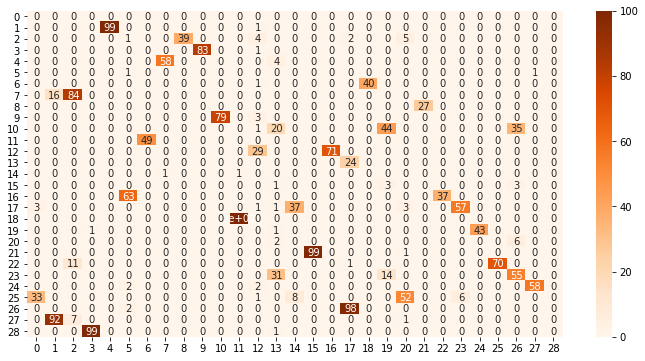

In [230]:
cm = cfm_dict[max_ari]
df_cm = pd.DataFrame(cm)
plt.figure(figsize=(12,6))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Oranges)
plt.show()

Если же в задаче будут использованы Doc2Vec- и Word2Vec-вектора без использования какой бы то ни было обработки, то результаты действительно получатся не такими высокими: 

In [231]:
for filename in glob.iglob('vectors_*.pickle', recursive=True):
    with open(filename, 'rb') as f:
        data_model = pickle.load(f)
        for alg in list_of_alg:
            print(alg,filename)
            pipeline = Pipeline([        ('clust', alg(n_clusters=28))
                                ])
            pipeline.fit(data_model)
            
            clust_labels = pipeline.named_steps['clust'].labels_

            print("Homogeneity:", homogeneity_score(labels, clust_labels))
            print("Completeness:", completeness_score(labels, clust_labels))
            print("V-measure",  v_measure_score(labels, clust_labels))
            ari= adjusted_rand_score(labels, clust_labels)
            print("Adjusted Rand-Index:",  ari)
            print('==============')

<class 'sklearn.cluster.k_means_.KMeans'> vectors_d2v_from_mystem.pickle
Homogeneity: 0.870869794863
Completeness: 0.85228923241
V-measure 0.861479337943
Adjusted Rand-Index: 0.700319373103
<class 'sklearn.cluster.hierarchical.AgglomerativeClustering'> vectors_d2v_from_mystem.pickle
Homogeneity: 0.881361624232
Completeness: 0.868015515439
V-measure 0.874637660681
Adjusted Rand-Index: 0.715862782206
<class 'sklearn.cluster.spectral.SpectralClustering'> vectors_d2v_from_mystem.pickle
Homogeneity: 0.605483947577
Completeness: 0.715680979758
V-measure 0.655986752092
Adjusted Rand-Index: 0.181558218148
<class 'sklearn.cluster.k_means_.KMeans'> vectors_d2v_from_pymorphy.pickle
Homogeneity: 0.874782173113
Completeness: 0.857196709985
V-measure 0.865900165485
Adjusted Rand-Index: 0.738555642877
<class 'sklearn.cluster.hierarchical.AgglomerativeClustering'> vectors_d2v_from_pymorphy.pickle
Homogeneity: 0.897940802913
Completeness: 0.883628227483
V-measure 0.890727023793
Adjusted Rand-Index: 0.7

Для отрисовки Agglomerative clustering:

In [ ]:
def plotClusters(a):
    z = hac.linkage(a, method='ward')
    hac.dendrogram(z)
    plt.tight_layout()
    plt.show()

### Обсуждение

В результате получилось, что Texterra действительно показывает наилучшие результаты по всем 9 типам кластеризации (по ARI), вот тут будет нарисован график:

Итак, в результате исследования были получены результаты по метрикам ARI и V-score, являющихся относительными величинами. То есть, полученные результаты говорят нам о том, что в большинстве случаев полученные с помощью алгоритмов метки кластеров были похожи на метки кластеров, проставленные людьми, но при этом пока ничего не понятно о том, действительно ли полученные кластеры будут интерпретируемы. 

Для этого мы решеили дополнительно провести ещё один эксперимент, разбив данные на 5 кластеров, чтобы проверить действительно ли рассматриваемые нами методы кластеризации способы разбивать документы по тематически схожим категориям:

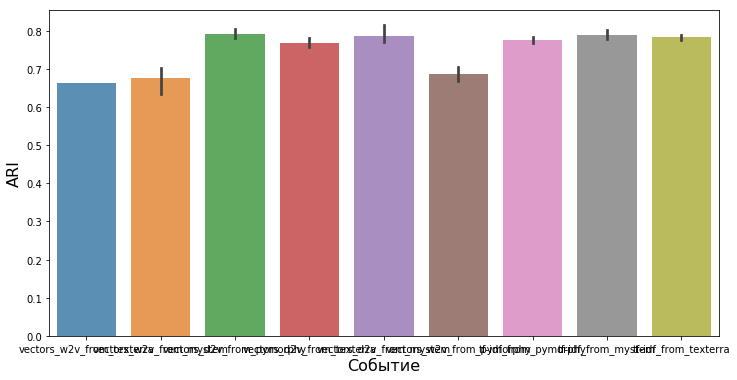

In [312]:
plt.figure(figsize=(12,6))
sns.barplot(list(ari_dict.values()), list(ari_dict.keys()), alpha=0.8)
plt.ylabel('ARI', fontsize=16)
plt.xlabel('Событие', fontsize=16)
plt.show();

Итак, в результате исследования были получены результаты по метрикам ARI и V-score, являющихся относительными величинами. То есть, полученные результаты говорят нам о том, что в большинстве случаев полученные с помощью алгоритмов метки кластеров были похожи на метки кластеров, проставленные людьми, но при этом пока ничего не понятно о том, действительно ли полученные кластеры будут интерпретируемы. 

Для этого мы решеили дополнительно провести ещё один эксперимент, разбив данные на 5 кластеров, чтобы проверить действительно ли рассматриваемые нами методы кластеризации способы разбивать документы по тематически схожим категориям:

In [285]:
pipeline = Pipeline([('tfidf', TfidfTransformer()),
                                 ('svd', TruncatedSVD(n_components=150)),
                                 ('norm', Normalizer()),
                                 ('clust', KMeans(n_clusters=5))
                                ])
pipeline.fit(vectors)
clust_labels = pipeline.named_steps['clust'].labels_

In [286]:
events_merged = []

for event in range(5):
    events = set([df_news.event_id.values[i] for i, x in enumerate(clust_labels) if x == event])
    events_merged.append(events)

In [287]:
for events_set in events_merged:
    for event in events_set:
        print(df_events.loc[df_events.index == event]['name'].values[0])
    print('=======')

Дональд Трамп вступил в должность президента США.
CNN показала фильм «Владимир Путин — самый влиятельный человек в мире».
теракт произошел в центре Лондона
В центре Киева был убит бывший депутат Госдумы РФ от КПРФ Денис Вороненков
SpaceX впервые в истории запустила и посадила уже летавшую ракету-носитель
Тиллерсон посещает Москву и встречается с Путиным
Несанкционированные акции в Москве апрель
Путин и Меркель в Сочи
Победа Макрона во Франции
Парламентские выборы в Великобритании
Горячая линия Президента Путина
Саммит G20
Единый день голосования
Скоропостижно скончался постпред России при ООН Виталий Чуркин.
Умер Дэвид рокфеллер
Юлию Самойлову не пустили на евровидении в Киеве
В центре Киева был убит бывший депутат Госдумы РФ от КПРФ Денис Вороненков
Умер Евгений Евтушенко
Горячая линия Президента Путина
Юлию Самойлову не пустили на евровидении в Киеве
SpaceX впервые в истории запустила и посадила уже летавшую ракету-носитель
Умер Евгений Евтушенко
Чемпионат мира по хоккею
Победа Макро

Как видно из полученных данных, некоторые кластеры действительно содержат очень тематически похожие новости: можно заметить выделенный набор новостей про чью-то кончину, набор новостей про митинги и набор новостей про политику. При этом почему-то отдельно выделился кластер из одной новости, а также кластер из достаточно разнородных новостей, которые трудно с первого взгляда отнести в какую-то конкретную категорию. Таким образом, при разбиении множества новостей на меньшее число кластеров (в данном случае на 5), 60% полученных кластеров будут интерпретируемы. В какой-то степени можно считать, что рассмотренные нами алгоритмы работают верно.

### Заключение

Таким образом, в данной работе мы сравнили производительность трёх алгоритмов лемматизации русского языка для 9 разных случаев с использованием разных методов векторизации "сырого текста" и разных методов кластеризации. 

В продолжение данной работы мы предполагаем расширить исследование на сравнение производительности дистрибутивных моделей (GloVe, FastText, StarSpace и т.д.) и дистрибутивно-тематических моделей (Potapenko et al. 2017), использовав задачу кластеризации новостей как downstream task в рамках extrinsic evaluation дистрибутивных моделей. Помимо этого, в будущем мы планируем выполнить вторую и последующие домашки по машинному обучению.

### Список литературы

1. Mikolov T. et al. Distributed representations of words and phrases and their compositionality //Advances in neural information processing systems. – 2013. – С. 3111-3119. 
2. Le Q., Mikolov T. Distributed representations of sentences and documents //Proceedings of the 31st International Conference on Machine Learning (ICML-14). – 2014. – С. 1188-1196.
3. Korobov M. Morphological analyzer and generator for Russian and Ukrainian languages //International Conference on Analysis of Images, Social Networks and Texts. – Springer, Cham, 2015. – С. 320-332.
4. Segalovich I. A Fast Morphological Algorithm with Unknown Word Guessing Induced by a Dictionary for a Web Search Engine //MLMTA. – 2003. – С. 273-280.
5. Turdakov D. Y. et al. Texterra: A framework for text analysis //Programming and Computer Software. – 2014. – Т. 40. – №. 5. – С. 288-295.